# Web Scraping

Basic tutorial using BeautifulSoup to extract forecast data for a particular city in U.S. from weather.gov website.  
Based on <a href="https://www.dataquest.io/blog/web-scraping-python-using-beautiful-soup/" target="_blank">this tutorial</a>.

If you are not confident with HTML, you can review the basics of the <a href="https://docs.google.com/presentation/d/1GonNbQS5eZUZIHmoM9GuGbDb-F1oOx6l8BMYGRYBbFQ/edit?usp=sharing" target="_blank">here</a>.

Additionally, you will need <a href="https://docs.mongodb.com/manual/installation/" target="_blank">MongoDB</a> to persist scraped data. In addition, you can use <a href="https://robomongo.org/" target="_blank">Robo3T</a> as UI client to access MongoDB.

In [1]:
# sudo pip install requests
# sudo pip install urllib3
# sudo pip install Pillow
# sudo pip install beautifulsoup4
# sudo pip install numpy
# sudo pip install pandas
# sudo pip install matplotlib
# sudo pip install pymongo

In [2]:
# Importing required libraries

import requests

from urllib.request import urlopen

from PIL import Image

from bs4 import BeautifulSoup

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from pymongo import MongoClient

!python --version

Python 2.7.18


In [3]:
# Defining the website URL and query parameters for the analysis
SITE_URL = "https://forecast.weather.gov/"
PAGE_URL = "{site_url}/MapClick.php?lat={lat}&lon={lon}"
LAT = 40.7146
LON = -74.0071

In [4]:
# Creating a connection to MongoDB
client = MongoClient("localhost", 27017)
db = client["weather"]
collection = db["forecast"]
db

Database(MongoClient(host=['localhost:27017'], document_class=dict, tz_aware=False, connect=True), 'weather')

In [5]:
# Downloading and storing in-memory the HTML returned by the weather server
page = requests.get(PAGE_URL.format(site_url = SITE_URL, lat = LAT, lon = LON))
print(page) # Success making the request

<Response [200]>


In [6]:
# HTML content is passed to BeautifulSoup for scraping analysis
soup = BeautifulSoup(page.content, "html.parser")

In [7]:
# Finding by id the tag containing the forecasts
seven_day = soup.find(id = "seven-day-forecast")

In [8]:
# Tags classed with `tombstone-container` contain the different forecast data points
forecast_items = seven_day.find_all(class_ = "tombstone-container")
print(len(forecast_items)) # 9 forecast data points founded

9


In [9]:
# Printint the HTML content for today's forecast
tonight = forecast_items[0]
print(tonight.prettify())

<div class="tombstone-container">
 <p class="period-name">
  Today
  <br/>
  <br/>
 </p>
 <p>
  <img alt="Today: Mostly sunny, with a high near 59. Southwest wind 10 to 13 mph. " class="forecast-icon" src="newimages/medium/sct.png" title="Today: Mostly sunny, with a high near 59. Southwest wind 10 to 13 mph. "/>
 </p>
 <p class="short-desc">
  Mostly Sunny
 </p>
 <p class="temp temp-high">
  High: 59 °F
 </p>
</div>


In [10]:
# Extracting info from the HTML content for today's forecast

period = tonight.find(class_ = "period-name").get_text()
print(period)

short_desc = tonight.find(class_ = "short-desc").get_text()
print(short_desc)

temp = tonight.find(class_ = "temp").get_text()
print(temp)

Today
Mostly Sunny
High: 59 °F


In [11]:
# Accessing to img tag directly by name
img = tonight.find("img")

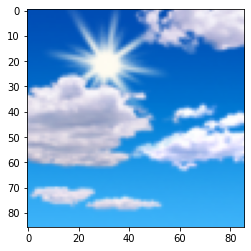

In [12]:
# Extracting and showing a static resource, the image best representing the forecast
f = urlopen(SITE_URL + img["src"])
a = Image.open(f)
plt.imshow(a)
plt.show()

In [13]:
# Extracting additional metadata from image
desc = img["title"]
print(desc)

Today: Mostly sunny, with a high near 59. Southwest wind 10 to 13 mph. 


In [14]:
# Reproducing previous extractions for all data points

periods = [pt.get_text() for pt in seven_day.select(".tombstone-container .period-name")]
print("Periods:", periods)

short_descs = [sd.get_text() for sd in seven_day.select(".tombstone-container .short-desc")]
print("Short descriptions:", short_descs)

temps = [t.get_text() for t in seven_day.select(".tombstone-container .temp")]
print("Temperatures:",temps)

descs = [d["title"] for d in seven_day.select(".tombstone-container img")]
print("Descriptions:", descs)

Periods: ['Today', 'Tonight', 'Saturday', 'SaturdayNight', 'Sunday', 'SundayNight', 'Monday', 'MondayNight', 'Tuesday']
Short descriptions: ['Mostly Sunny', 'ScatteredShowers', 'ScatteredShowers', 'Partly Cloudy', 'Mostly Sunnythen IsolatedShowers', 'DecreasingClouds', 'Sunny', 'Mostly Cloudy', 'Partly Sunny']
Temperatures: ['High: 59 °F', 'Low: 48 °F', 'High: 55 °F', 'Low: 43 °F', 'High: 52 °F', 'Low: 41 °F', 'High: 57 °F', 'Low: 50 °F', 'High: 66 °F']
Descriptions: ['Today: Mostly sunny, with a high near 59. Southwest wind 10 to 13 mph. ', 'Tonight: Scattered showers.  Mostly cloudy, with a low around 48. South wind 6 to 8 mph.  Chance of precipitation is 50%.', 'Saturday: Scattered showers, with thunderstorms also possible after 2pm.  Partly sunny, with a high near 55. South wind 8 to 14 mph becoming west in the afternoon.  Chance of precipitation is 40%.', 'Saturday Night: Partly cloudy, with a low around 43. West wind around 10 mph. ', 'Sunday: Isolated showers after 2pm.  Partly 

In [15]:
# Transforming extracted data to a tabular format
weather_df = pd.DataFrame({
    "period": periods,
    "short_desc": short_descs,
    "temp": temps,
    "desc": descs
})

In [16]:
# Printing tabular forecast data
weather_df

,period,short_desc,temp,desc
0,Today,Mostly Sunny,High: 59 °F,"Today: Mostly sunny, with a high near 59. Sout..."
1,Tonight,ScatteredShowers,Low: 48 °F,"Tonight: Scattered showers. Mostly cloudy, wi..."
2,Saturday,ScatteredShowers,High: 55 °F,"Saturday: Scattered showers, with thunderstorm..."
3,SaturdayNight,Partly Cloudy,Low: 43 °F,"Saturday Night: Partly cloudy, with a low arou..."
4,Sunday,Mostly Sunnythen IsolatedShowers,High: 52 °F,Sunday: Isolated showers after 2pm. Partly su...
5,SundayNight,DecreasingClouds,Low: 41 °F,"Sunday Night: Mostly cloudy, then gradually be..."
6,Monday,Sunny,High: 57 °F,"Monday: Sunny, with a high near 57."
7,MondayNight,Mostly Cloudy,Low: 50 °F,"Monday Night: Mostly cloudy, with a low around..."
8,Tuesday,Partly Sunny,High: 66 °F,"Tuesday: Partly sunny, with a high near 66."


In [17]:
# Cleaning temperature column
weather_df["temp_num"] = weather_df["temp"].apply(lambda x: x.split(" ")[1]).astype("int")

In [18]:
# Printing data, again
weather_df

,period,short_desc,temp,desc,temp_num
0,Today,Mostly Sunny,High: 59 °F,"Today: Mostly sunny, with a high near 59. Sout...",59
1,Tonight,ScatteredShowers,Low: 48 °F,"Tonight: Scattered showers. Mostly cloudy, wi...",48
2,Saturday,ScatteredShowers,High: 55 °F,"Saturday: Scattered showers, with thunderstorm...",55
3,SaturdayNight,Partly Cloudy,Low: 43 °F,"Saturday Night: Partly cloudy, with a low arou...",43
4,Sunday,Mostly Sunnythen IsolatedShowers,High: 52 °F,Sunday: Isolated showers after 2pm. Partly su...,52
5,SundayNight,DecreasingClouds,Low: 41 °F,"Sunday Night: Mostly cloudy, then gradually be...",41
6,Monday,Sunny,High: 57 °F,"Monday: Sunny, with a high near 57.",57
7,MondayNight,Mostly Cloudy,Low: 50 °F,"Monday Night: Mostly cloudy, with a low around...",50
8,Tuesday,Partly Sunny,High: 66 °F,"Tuesday: Partly sunny, with a high near 66.",66


In [19]:
# What is the mean forecasted temperature?
round(weather_df["temp_num"].mean(), 2)

52.33

Text(0.5, 1.0, 'Forecasted temperature (ºF) for next 4 days')

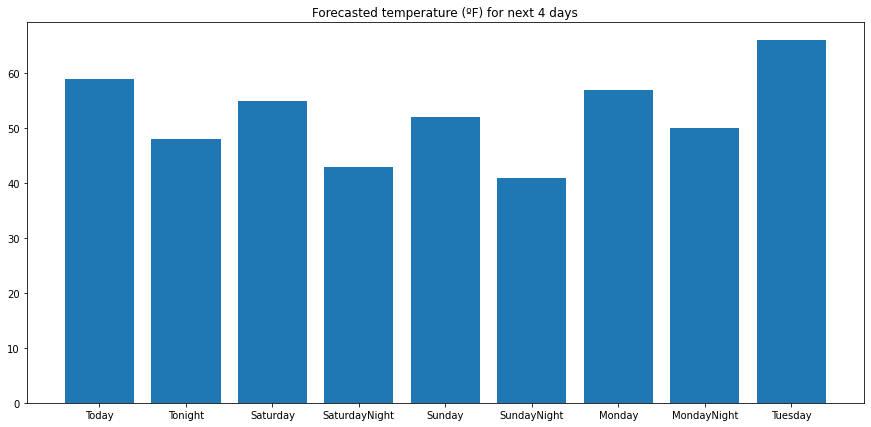

In [20]:
# Visualizing some relevant information about forecast weather
plt.figure(figsize = (15, 7))
plt.bar(weather_df["period"], weather_df["temp_num"])
plt.title("Forecasted temperature (ºF) for next 4 days")

In [21]:
# Transforming df to dict
weather_dict = weather_df.to_dict(orient = "row")

/tmp/ipykernel_3963/403319095.py:2: FutureWarning: Using short name for 'orient' is deprecated. Only the options: ('dict', list, 'series', 'split', 'records', 'index') will be used in a future version. Use one of the above to silence this warning.
  weather_dict = weather_df.to_dict(orient = "row")


In [22]:
weather_dict

[{'period': 'Today',
  'short_desc': 'Mostly Sunny',
  'temp': 'High: 59 °F',
  'desc': 'Today: Mostly sunny, with a high near 59. Southwest wind 10 to 13 mph. ',
  'temp_num': 59},
 {'period': 'Tonight',
  'short_desc': 'ScatteredShowers',
  'temp': 'Low: 48 °F',
  'desc': 'Tonight: Scattered showers.  Mostly cloudy, with a low around 48. South wind 6 to 8 mph.  Chance of precipitation is 50%.',
  'temp_num': 48},
 {'period': 'Saturday',
  'short_desc': 'ScatteredShowers',
  'temp': 'High: 55 °F',
  'desc': 'Saturday: Scattered showers, with thunderstorms also possible after 2pm.  Partly sunny, with a high near 55. South wind 8 to 14 mph becoming west in the afternoon.  Chance of precipitation is 40%.',
  'temp_num': 55},
 {'period': 'SaturdayNight',
  'short_desc': 'Partly Cloudy',
  'temp': 'Low: 43 °F',
  'desc': 'Saturday Night: Partly cloudy, with a low around 43. West wind around 10 mph. ',
  'temp_num': 43},
 {'period': 'Sunday',
  'short_desc': 'Mostly Sunnythen IsolatedShower

In [23]:
# Storing extracted information for further analysis
collection.insert_many(weather_dict)